# Diffusion Examples

#### Adapted from: https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb

https://colab.research.google.com/drive/1_kbRZPTjnFgViPrmGcUsaszEdYa8XTpq?usp=sharing

https://colab.research.google.com/drive/1iZnEI2sZhL_fqOHjhvqrqco3cLXCllyK?usp=sharing#scrollTo=OFcXcSHCRZkR

https://daily-philosophy.com/stunning-ai-generated-art-stable-diffusion/

In [2]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 27.9 MB/s 
     |████████████████████████████████| 182 kB 56.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 32.2 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 7.6 MB 56.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 16.7 MB/s 


In [3]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [6]:
# make sure you're logged in with `huggingface-cli login`
pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

## generate an image from text

0it [00:00, ?it/s]

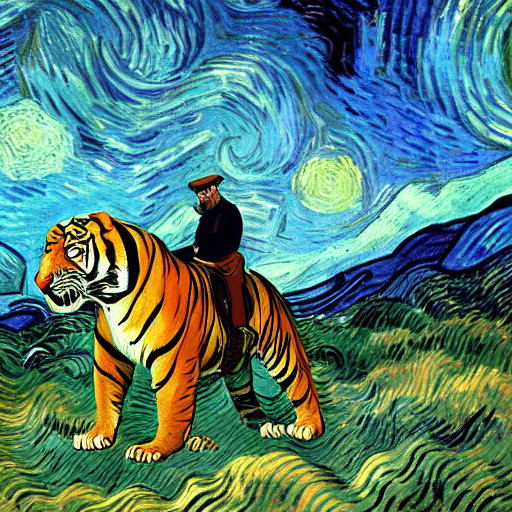

In [7]:
prompt = 'man ridding a tiger in vincent van gogh style, trending on Artstation, highly detailed, artstation, concept art, sharp focus, illustration, cinematic lighting, atmospheric, detailedu'
with autocast(device):
  image = pipe(prompt)['sample'][0]
image

In [8]:
image.save("/img2.png")

0it [00:00, ?it/s]

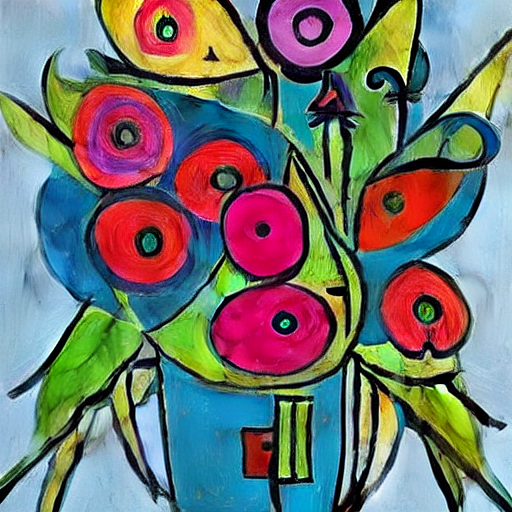

In [25]:
#import torch

generator = torch.Generator("cuda").manual_seed(1024)

prompt = 'A flower in Picasso style'
with autocast(device):
  image = pipe(prompt,generator=generator,height=512, width=512,num_inference_steps=10)['sample'][0]
image

In [14]:
image2 = image.resize((1820, 1080))

In [15]:
image2.save("/img3.png")

In [62]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

0it [00:00, ?it/s]

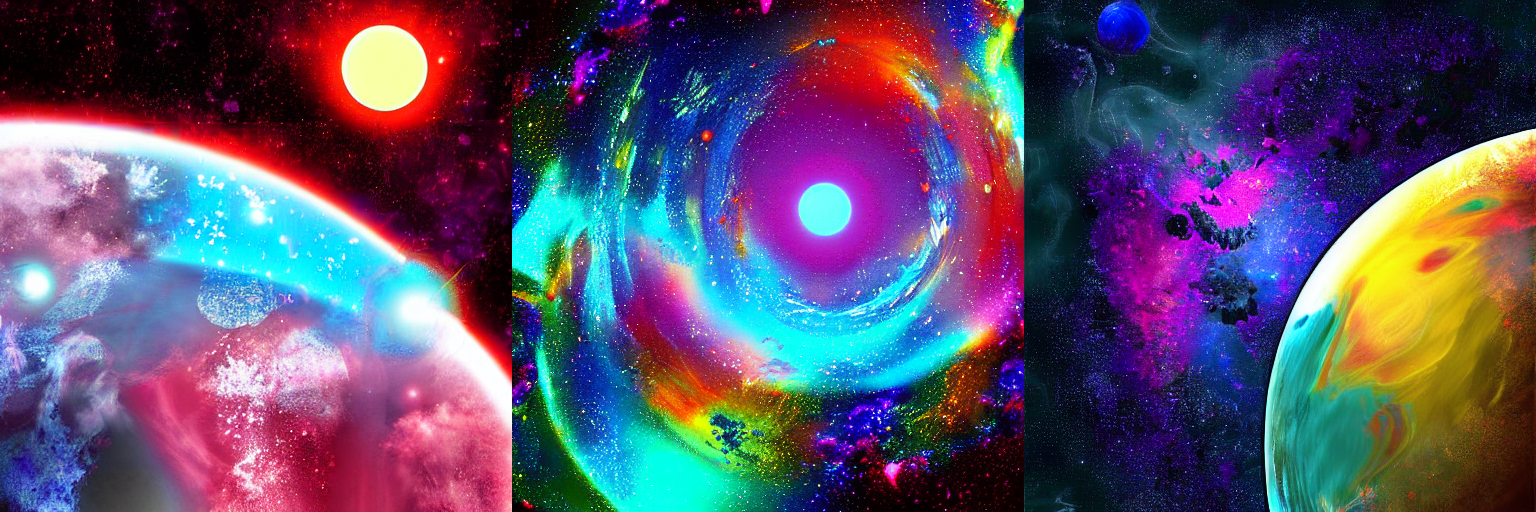

In [64]:
n_images = 3
prompts = ['colorful Planet in space digital art'] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50)['sample']
image_grid(images, rows=1, cols=3)

## Genarate image from image

In [38]:
# let's download an initial image
url = "https://images.pexels.com/photos/7960253/pexels-photo-7960253.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"

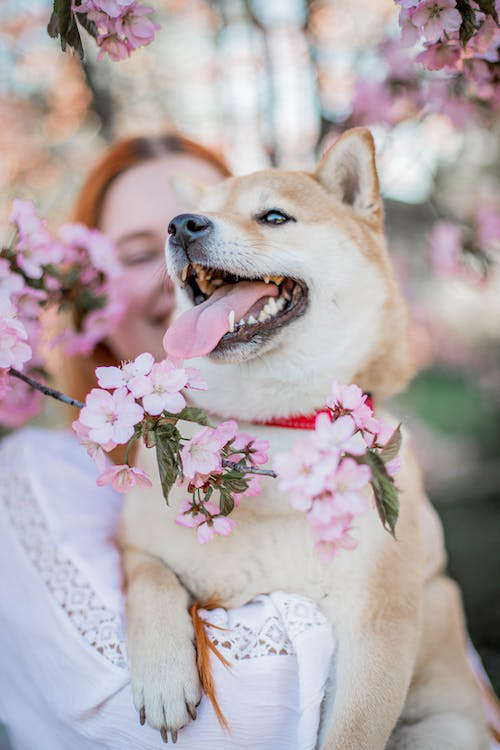

In [39]:
from torch import autocast
import torch
import requests
from PIL import Image
from io import BytesIO

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image

In [43]:
init_image = init_image.resize((512, 512))

In [56]:
prompt = "a colorful dog, trending on artstation picasso style"

with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_image,strength=0.75, guidance_scale=2.5,num_inference_steps=50)["sample"]


0it [00:00, ?it/s]

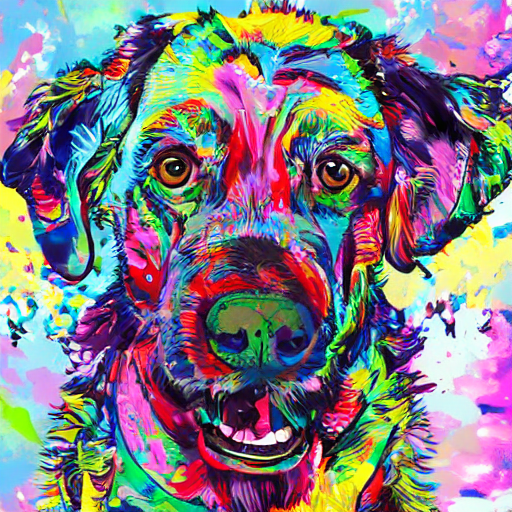

In [57]:
images[0]

## save image

In [61]:
images[0].save("/img34.png")